Ali Al Kadhim and Harrison B. Prosper <br>
Department of Physics, Florida State University <br>


In [94]:
import numpy as np; import pandas as pd
import scipy as sp; import scipy.stats as st
import torch; import torch.nn as nn
from numba import njit
from sklearn.preprocessing import StandardScaler; from sklearn.model_selection import train_test_split
import matplotlib as mp; import matplotlib.pyplot as plt; plt.style.use('seaborn-deep')
mp.rcParams['agg.path.chunksize'] = 10000
# %matplotlib inline
import copy; import sys; import os
from IPython.display import Image, display
#sometimes jupyter doesnt initialize MathJax automatically for latex, so do this
import ipywidgets as wid; wid.HTMLMath('$\LaTeX$')

HTMLMath(value='$\\LaTeX$')

In particle physics, the most important experiment is a counting experiment, represented by a Poisson probability model, where $N$ is the observed count and $\theta$ is a nuissance parameter, hence the probability model is $P(N|\theta) = \text{Poisson}(N,\theta)$.
where the most important parameter is the cross section $\sigma$, which is related to the mean event count $N = \sigma \mathcal{L} +b$. 


# For the two-parameter problem, the Poisson mean$=\theta+\nu$, and the probability model is given by

$$p(N,M|\theta, \nu) = \text{Poiss}(N; \theta+\nu)\text{Poiss}(M;\nu) =L(\theta, \nu)= \frac{e^{-(\theta+\nu)} (\theta+\nu)^N }{N !} \ \frac{e^{-\nu} \nu^M}{M !}$$



Where $\nu$ is the nuissance parameter, $\theta$ is the paramter of interest (for which we want to estimate upper limits). 


### Observed Data:

   * $N$ (counts for signal)
   * $M$ (counts for background)

### Parameters:

* $\theta$ (parameter of interest)

* $\nu$ (nuissance parameter)

### Auxiliary (simulated) Data (simulated on-the-fly for each observation)

* $n$

* $m$


    
The standard procedure for removal of nuissance parameters is Bayesian marginalization, but in this study we adopt LFI with frequentest methods.

In this notebook we generate data comprising the quadruplets $(Z_i, \theta_i, \nu_i, N_i, M_i)$ where 

$
\begin{align}
\theta & \sim \textrm{uniform}(0, 20), \\
\nu & \sim \textrm{uniform}(0, 20), \\
n & \sim \textrm{poisson}(\theta + \nu),\\
m & \sim \textrm{poisson}(\nu),\\
N & \sim \textrm{uniform}(0,10),\\
M & \sim \textrm{uniform}(0, 10), \textrm{ and } \\
Z & = I[ \lambda_{\textrm{gen}} \leq \lambda_D (D, \theta) ],
\end{align}
$

where the size of each of these samples is $B'$, $I$ is the indicator function, and $\lambda_D (D, \theta)= \lambda(N, M, \theta)$ is our chosen test statistic

$$ \lambda = - 2 \log{\frac{p(n,m|\theta, \hat{\nu}(\theta) )}{ p(n,m|\hat{\theta}, \hat{\nu}(\theta) )}} = -2 \log \frac{L_{\text{prof}} \big(n, m, \theta, \hat{\nu}(\theta) \big) }{L_{\text{prof}} \big( n, m, \hat{\theta}_{\text{MLE}}, \hat{\nu}(\theta) \big)}$$

Where $L_{\text{prof}} (n, m, \theta, \hat{\nu}(\theta))$ is the profiled likelihood. The maximum likelihood estimate of $\hat{\theta}$, 
$$\hat{\theta}_{\text{MLE}}=n-m$$, and

$$\log{p(n,m|\theta,\nu)} = -(\theta+\nu)+n\log{(\theta+\nu)|-\nu+m\log{\nu}} + \text{constants}$$
The MLE $\hat{\nu}(\theta)$ is attained by solving $\frac{\partial \log{p(n,m|\theta,\nu)}}{ \partial \nu} =0$ leading to 

$$\hat{\nu}(\theta)=\left(g+\sqrt{g^2 + 8 m \theta} \right)/4$$
where $g \equiv n+m-2 \theta$.

And since $\nu$ has been marginalized in the likelihood, $\lambda$ only depends on $\theta,\n,m$ (but is used as a test statistic for $\theta$ only), and is only "slighly" dependent on $n,m$ since they're really not the observed data but instead simulations on the fly. $\lambda=\lambda(\theta,n,m)$

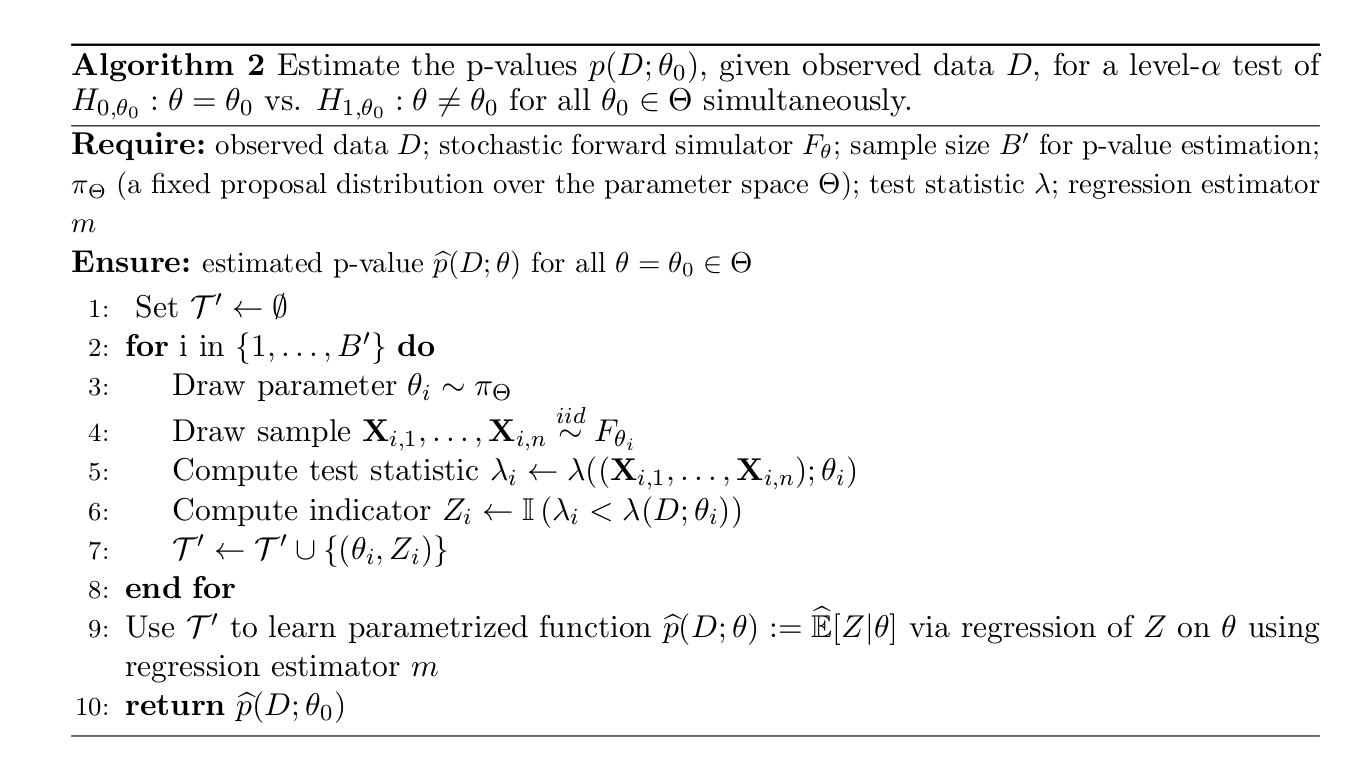

In [95]:
algorithm2 = Image('images/Algorithm2.jpg'); display(algorithm2)

In [96]:
def mkdir(dir_):
    """make a directory without overwriting what's in it if it exists"""
    # assert isinstance(dir_, str)
    try:
        os.system('mkdir -p %s' % str(dir_) )
    except Exception:
        pass

In [97]:
mkdir('utils')

In [98]:
# %writefile 'src/utils.py'

def import_base_stack():
    import numpy as np; import pandas as pd
    import scipy as sp; from numba import njit

@njit
def DR(s, theta):
    return sp.special.gammainc(s, theta)

@njit
def DL(s, theta):
    return 1 - sp.special.gammainc(s+1, theta)


def L_prof(n,m,theta):
    k=1
    k1 = k+1
    k2 = 0.5/k1
    g = n+m - k1*theta
    nu_hat = k2* (g+ np.sqrt(g*g +4*k1*m*theta))
    p1 = st.poisson.pmf(n, mu = theta + nu_hat)
    p2 = st.poisson.pmf(m, mu = k * nu_hat)
    
    return p1*p2


def theta_hat(n,m, MLE=True):
    theta_hat = n-m
    
    if not MLE:
        theta_hat = theta_hat * (theta_hat > 0)
    return theta_hat

# @njit
def lambda_test(theta, n, m, MLE=True):
    Ln = L_prof(n,m,theta)
    Ld = L_prof(n,m, theta_hat(n,m, MLE))
    lambda_  = -2*np.log(Ln/Ld)
    return np.array(lambda_)

In [99]:
chi2_exp_size=40

def run_sim(theta, nu, MLE, lambda_size):
    """Sample n ~ Pois(theta+nu), 
              m ~ Pois(nu), 
    and compute 
              lambda(theta, n, m)
              
    return: (n, m, lambda_), where each are np arrays of length lambda_size
    """
    n = st.poisson.rvs(theta+nu, size=lambda_size)
    m = st.poisson.rvs(nu, size=lambda_size)
    lambda_ = lambda_test(theta, n, m, MLE=MLE)
    return (n, m, lambda_)

def run_sims(points, MLE):
    """
    Run an entire simulation, that is, generate n and m from 
    run_sim above, and calculate lambda, for
    
    input: a tuple of (theta, nu) scalars
    
    Reurns:df, lambda_results
    
    where lambda_results is a list of tuples 
        (n, m, lambda_, theta, nu)
    and df is just a dataframe of [n,m,lambda,theta,nu]

    """
    lambda_results=[]
    df=pd.DataFrame()
    for p in points:
        theta, nu = p
        df['theta']=theta
        df['nu']=nu
        n, m, lambda_ = run_sim(theta, nu, MLE, lambda_size =chi2_exp_size)
        df['n'] = n
        df['m'] = m
        df['lambda']=lambda_
        lambda_results.append((n, m, lambda_, theta, nu))
    
        print( '\n \n (theta, nu) =  (%.f, %.f) \n ' % (theta, nu) )
        print(f'\t \t with associated n =  {n}, \n \n \t \t m = {m}, \n \n \t \t lambda = {lambda_}'  )
    return df, lambda_results

def plot_one(lambda_, theta, nu, ax):
    """Histogram the CDF of  lambda_t = -2log(Lp(theta)/Lp(theta_hat)), 
    for a given (fixed) theta and nu.
    Also, plot the actual CDF of a chi^2 distribution with 1 free parameter 
    (since only theta is left after we profile nu) """
    ftsize = 16; xmin= 0; xmax= 10
    ymin= 0; ymax= 1
    x_range = (xmin, xmax)
    y_range = (ymin, ymax)
    ax.set_xlim(x_range); ax.set_ylim(y_range)
    ax.set_xlabel(r'$\lambda (\theta, n, m, \hat{\nu}(\theta))$',fontsize=ftsize)
    ax.set_ylabel(r'cdf$(\lambda)$', fontsize=ftsize)
    ##########HISTOGRAM CDF OF LAMBDA####################
    ax.hist(lambda_, bins=5*xmax, range=x_range,
    color=(0.8,0.8,0.9),
    density=True, cumulative=True,
    histtype='stepfilled', edgecolor='black', label=r'CDF$(\lambda)$')
    ############################################################
    ########### HISTOGRAM CDF OF THE CHI2 OF OF X WITH 1 DOF
    #x is not theta, that's the whole point of Wilks thm, x is an arbitrary RV
    x = np.arange(0, xmax, 0.2)
    y = st.chi2.cdf(x, 1)
    ax.plot(x, y, color='blue',
    linewidth=2, label=r'CDF$(\chi^2_1)$')
    # annotate
    xwid = (xmax-xmin)/12
    ywid = (ymax-ymin)/12
    xpos = xmin + xwid/2
    ypos = ymin + ywid*2
    ax.text(xpos, ypos,
    r'$ \theta = %d, \nu = %d$' % (theta, nu),
    fontsize=ftsize)
    ax.legend(loc='upper right',fontsize=10)

1. Generate one scalar $\theta$ and one scalar $\nu$
2. Generate $\lambda(\theta,\nu)$ of size $N$, the distribution of this $\lambda$ will approach the CDF of a $\chi^2_{dof}(x)$ of an RV of one dof (since $\theta$ is the only free parameter left)
4. Observe that this test statistc will be dependent on the value of $\nu$ in the non-MLE case, which is not desirable since we want to be insensetive to nuissance parameters for maximal statistal power


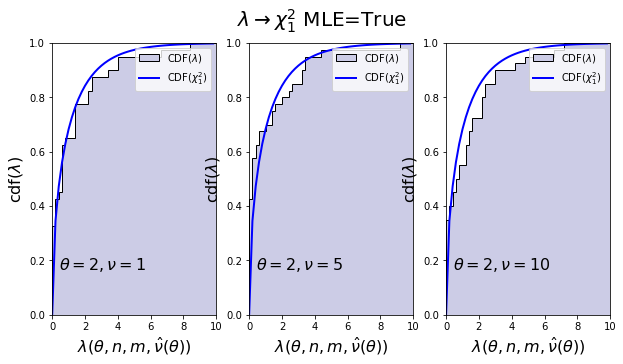

In [101]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=True
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle(r'$\lambda \rightarrow \chi^2_1$; MLE=%s' % str(MLE), fontsize=20); plt.show()

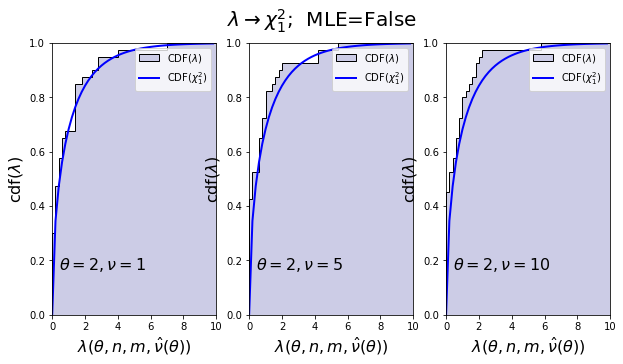

In [105]:
#points=(theta,nu)
points_1 = (2, 1)
points_2 = (2, 5)
points_3 = (2, 10)
MLE=False
_, _ , lambda_1 = run_sim(theta=points_1[0], nu=points_1[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_2 = run_sim(theta=points_2[0], nu=points_2[1], MLE=MLE, lambda_size=chi2_exp_size)
_, _ , lambda_3 = run_sim(theta=points_3[0], nu=points_3[1], MLE=MLE, lambda_size=chi2_exp_size)

fig, ax = plt.subplots(1,3, figsize=(10,5))
plot_one(lambda_1, points_1[0], points_1[1], ax[0])
plot_one(lambda_2, points_2[0], points_2[1], ax[1])
plot_one(lambda_3, points_3[0], points_3[1], ax[2])
fig.suptitle(r'$\lambda \rightarrow \chi^2_1$;  MLE=False', fontsize=20); plt.show()

Generate 6 pairs (tuples) of $(\theta, \nu)$ values

In [106]:
points = [(theta, nu) for theta, nu in 
          zip(np.random.randint(low=1,high=4,size=3), 
              np.random.randint(low=0,high=4,size=3))]

In [107]:
df, results = run_sims(points, MLE=True)


 
 (theta, nu) =  (2, 1) 
 
	 	 with associated n =  [1 6 1 4 4 1 1 4 3 1 2 6 5 4 3 2 2 3 1 1 6 1 4 3 2 4 2 5 4 4 3 2 5 2 2 4 1
 2 5 1], 
 
 	 	 m = [1 1 0 1 1 0 0 1 0 2 0 1 2 0 1 2 2 1 1 0 2 0 0 2 1 1 3 2 2 2 1 0 1 1 1 0 0
 1 1 1], 
 
 	 	 lambda = [ 1.5097123   1.47928694  0.61370564  0.21388676  0.21388676  0.61370564
  0.61370564  0.21388676  0.43279065  2.51671107 -0.          1.47928694
  0.1475477   1.54517744 -0.          0.90394862  0.90394862 -0.
  1.5097123   0.61370564  0.52939123  0.61370564  1.54517744  0.19157584
  0.29970658  0.21388676  1.66020193  0.1475477  -0.         -0.
 -0.         -0.          0.74478362  0.29970658  0.29970658  1.54517744
  0.61370564  0.29970658  0.74478362  1.5097123 ]

 
 (theta, nu) =  (2, 3) 
 
	 	 with associated n =  [5 8 6 2 2 4 5 6 2 8 3 4 2 2 6 4 2 4 2 4 7 5 6 5 7 2 4 5 5 4 7 5 3 1 2 3 4
 5 9 5], 
 
 	 	 m = [2 3 3 1 2 2 5 4 3 3 4 8 4 3 2 3 0 3 3 6 1 3 5 2 0 2 4 8 3 1 9 5 1 2 2 0 3
 3 1 4], 
 
 	 	 lambda = [ 0.1475477   0.85938633  

In [108]:
df.head()

,theta,nu,n,m,lambda
0,3,3,4,3,0.537895
1,3,3,8,3,0.378962
2,3,3,5,1,0.178305
3,3,3,5,1,0.178305
4,3,3,6,4,0.098241


In [109]:
n, m, lambda_, theta, nu =results[1]
print(f'results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  \n {n}, \n {m}, \n {lambda_}, \n {theta}, \n {nu})' )
print(f'''\n (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ({n.shape}, \t {m.shape}, \t {lambda_.shape}, \t {theta.size}, \t {nu.size})''')

results[1] =  (n1, m1, lambda1, theta1, nu1) =  (  
 [5 8 6 2 2 4 5 6 2 8 3 4 2 2 6 4 2 4 2 4 7 5 6 5 7 2 4 5 5 4 7 5 3 1 2 3 4
 5 9 5], 
 [2 3 3 1 2 2 5 4 3 3 4 8 4 3 2 3 0 3 3 6 1 3 5 2 0 2 4 8 3 1 9 5 1 2 2 0 3
 3 1 4], 
 [ 0.1475477   0.85938633  0.11325573  0.29970658  0.90394862 -0.
  0.39239727 -0.          1.66020193  0.85938633  1.2288131   2.96578989
  2.51359335  1.66020193  0.52939123  0.1396362  -0.          0.1396362
  1.66020193  1.56151451  2.34923351 -0.          0.09005222  0.1475477
  5.70406053  0.90394862  0.485543    1.89717852 -0.          0.21388676
  0.9900146   0.39239727 -0.          2.51671107  0.90394862  0.43279065
  0.1396362  -0.          4.34347151  0.10956358], 
 2, 
 3)

 (n.shape, m.shape, lambda_.shape, theta.size, nu.size) = 
      ((40,), 	 (40,), 	 (40,), 	 1, 	 1)


In [56]:
data_2_param=pd.read_csv('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', nrows=10000, usecols=['theta','nu', 'N', 'M'])
data_2_param.head()

,theta,nu,N,M
0,19.597712,10.387874,5,6
1,13.316589,0.052172,1,6
2,9.565929,2.031794,3,6
3,19.145463,8.600285,9,3
4,7.994914,7.861142,8,2


In [111]:
thetaMin, thetaMax =  0, 3
nuMin, nuMax = 0, 3
Mmin, Mmax =  0 , 3
Nmin, Nmax =  0,3

def generate_training_data(Bprime, MLE, save_data=False):
    """Generate the training data, that is, features=[theta, nu, N, M], targets=Z"""
    #sample theta and nu from uniform(0,20)
    theta = st.uniform.rvs(thetaMin, thetaMax, size=Bprime)
    # nu = st.uniform.rvs(nuMin, nuMax, size=Bprime)
    nu=3
    #n,m ~ F_{\theta,\nu}, ie our simulator. sample n from a Poisson with mean theta+nu 
    n = st.poisson.rvs(theta+ nu, size=Bprime)
    #sample m from a poisson with mean nu
    m = st.poisson.rvs(nu, size=Bprime)
    
    #sample our observed counts (N,M), which take the place of D
    N = np.random.randint(Nmin, Nmax, size=Bprime)
    M = np.random.randint(Mmin, Mmax, size=Bprime)
    SUBSAMPLE=10
    print('n=', n[:SUBSAMPLE])
    print('m=', m[:SUBSAMPLE])
    print('N=', N[:SUBSAMPLE])
    print('M=', M[:SUBSAMPLE])
    lambda_gen = lambda_test(theta, n, m, MLE)
    print('lambda_gen= ', lambda_gen[:SUBSAMPLE])
    lambda_D = lambda_test(theta, N, M, MLE)
    print('lambda_D= ', lambda_D[:SUBSAMPLE])
    #if lambda_gen <= lambda_D: Z=1, else Z=0
    Z = (lambda_gen <= lambda_D).astype(np.int32)
    
    data_2_param = {'Z' : Z, 'theta' : theta, 'nu': nu, 'N':N, 'M':M}

    data_2_param = pd.DataFrame.from_dict(data_2_param)
    if save_data:
        data_2_param.to_csv('data/two_parameters_N_M_Uniformly_sampled_1M.csv')

    print('\n')
    print(data_2_param.describe())
    return data_2_param

In [50]:
Train_data_MLE_True = generate_training_data(Bprime=10000, MLE=True, save_data=False)

n= [2 3 8 5 7 5 6 4 3 3]
m= [1 3 1 2 5 0 1 4 1 4]
N= [2 2 2 1 0 0 1 1 1 1]
M= [0 0 2 2 0 1 2 2 2 0]
lambda_gen=  [0.06148534 0.13869842 3.01888418 0.45201926 0.05971905 6.88495553
 1.41013678 0.0616186  0.34049371 1.75080888]
lambda_D=  [1.62205912 0.93766412 1.10211071 1.55825351 5.70173546 1.43281064
 2.61306078 0.93929107 1.11076481 1.32317722]


                  Z         theta       nu            N             M
count  10000.000000  10000.000000  10000.0  10000.00000  10000.000000
mean       0.660600      1.483293      3.0      0.98190      1.014100
std        0.473529      0.865100      0.0      0.81648      0.814842
min        0.000000      0.000198      3.0      0.00000      0.000000
25%        0.000000      0.725775      3.0      0.00000      0.000000
50%        1.000000      1.485878      3.0      1.00000      1.000000
75%        1.000000      2.231648      3.0      2.00000      2.000000
max        1.000000      2.999935      3.0      2.00000      2.000000


-----------


In [113]:
# %writefile data/dataloader.py

def split_t_x(df, target, source):
    # change from pandas dataframe format to a numpy 
    # array of the specified types
    t = np.array(df[target])
    x = np.array(df[source])
    return t, x

def load_df(df_name, SUBSAMPLE):
    """ returns the dataframe, can be used if the dataframe is saved in csv format
    of if it is already in dataframe format (e.g. generated in this notebook). """
    if isinstance(df_name,str):
        df = pd.read_csv('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', 
                         nrows=SUBSAMPLE)
    else:
        df = df_name[:SUBSAMPLE]
    return df

def get_batch(x, batch_size):
    # the numpy function choice(length, number)
    # selects at random "batch_size" integers from 
    # the range [0, length-1] corresponding to the
    # row indices.
    rows    = np.random.choice(len(x), batch_size)
    batch_x = x[rows]
    # batch_x.T[-1] = np.random.uniform(0, 1, batch_size)
    return batch_x


def get_data_sets(simulate_data=False, batchsize=100):
    """write custom data generator because who wants to read pytorch's DataLoader source code
    (and its sometimes slow for some reason)"""
    if simulate_data:
        Train_data_MLE_True = generate_training_data(Bprime=10000, MLE=True, save_data=False)
        
    data=load_df('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', SUBSAMPLE=10000)#This is MLE DATA!
    
    train_data, test_data = train_test_split(data, 
                                         test_size=0.2)
    #split the train data (0.8 of whole set) again into 0.8*0.8=0.64 of whole set
    train_data, valid_data = train_test_split(train_data, test_size=0.2)
    train_data = train_data.reset_index(drop=True)
    valid_data = valid_data.reset_index(drop=True)
    test_data  = test_data.reset_index(drop=True)

    target='Z'
    source = ['theta','nu','N','M']
    train_t, train_x = split_t_x(train_data, target=target, source=source)
    valid_t, valid_x = split_t_x(valid_data, target=target, source=source)
    test_t,  test_x  = split_t_x(test_data,  target=target, source=source)
    
    def training_set_features():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_x, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_features():
        #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            batch_x = get_batch(test_x,batchsize)
            #index of one of the items in our examples
            yield batch_x


    def training_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(train_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    def evaluation_set_targets():
            #start with an infinite loop, so that you can keep calling next (i.e. set = train_set(); set.next() ) until you run out of training examples
        while True:
            #get a random batch of the defined size
            batch_x = get_batch(test_t, batchsize)
            #print('batch_x', batch_x)
            #index of one of the items in our examples
            yield batch_x

    return training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets

In [116]:
training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=100)

first_features_batch = next(training_set_features())
print('first features batch \n', first_features_batch[:5])
print('\nfirst features batch shape \n', first_features_batch.shape)

first features batch 
 [[14.61227293 16.33824918  3.          1.        ]
 [ 7.6165708  10.4921734   6.          8.        ]
 [ 4.52527591  5.13933889  6.          3.        ]
 [11.38945602 11.75785805  7.          5.        ]
 [15.50261758 14.75573331  2.          7.        ]]

first features batch shape 
 (100, 4)


In [119]:
def binsize(data_df_or_Bprime):
    """ decide on the number of bins in a histogram according to Struge's rule"""
    if isinstance(data_df_or_Bprime,pd.core.frame.DataFrame):
        bin_count = int(np.ceil(np.log2(data_df_or_Bprime.shape[0])) + 1)
    elif isinstance(data_df_or_Bprime, int):
        bin_count = int(np.ceil(np.log2(data_df_or_Bprime)) + 1)
    return bin_count

XMIN  = 0
XMAX  = 20
NU    = 3#set
Bprime = 1000
# D is a list of (N,M) pairs
D     = [(1, 0), (2, 0), (3, 0), 
         (1, 1), (2, 1), (3, 1)]

Plot the histogrammed function the histogrammed function $h(\tilde{\theta}, \nu, N, M) = h(\theta_{min}, \theta_{max}, \nu, N, M)$ where $\tilde{\theta}$ means that it is simulated (inside the function).

In [221]:
def make_hist_data(Bprime,
              thetamin, thetamax,
              nu, N, M,
                nbins=200,
             MLE=True):

    theta = st.uniform.rvs(thetamin, thetamax, size=Bprime)
    n = st.poisson.rvs(theta + nu, size=Bprime)
    m = st.poisson.rvs(nu, size=Bprime)
    
    Z = (lambda_test(theta, n, m, MLE=MLE) < 
         lambda_test(theta, N, M, MLE=MLE)).astype(np.int32)

    thetarange = (thetamin, thetamax)
    # bins = binsize(Bprime)

    # weighted histogram   (count the number of ones per bin)
    y1, bb = np.histogram(theta, 
                          bins=nbins, 
                          range=thetarange, 
                          weights=Z)
    
    # unweighted histogram (count number of ones and zeros per bin)
    yt, _ = np.histogram(theta, 
                         bins=nbins, 
                         range=thetarange)

    y =  y1 / yt    
    
    return y, bb

In [188]:
h, h_bins = make_hist_data(Bprime=1000, thetamin=0,thetamax=20, nu=3,N=1,M=1,MLE=True)
h

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


array([0.        , 0.18181818, 0.28571429, 0.2       , 0.14285714,
       0.        , 1.        , 0.        , 0.66666667, 0.5       ,
       0.66666667, 0.66666667, 1.        , 0.25      , 0.8       ,
       1.        , 1.        , 0.5       , 1.        , 1.        ,
       0.75      , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.75      , 0.75      , 0.83333333, 0.5       ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.66666667, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.66666667, 1.        , 0.88888889, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.85714286,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [191]:
def plot_one_hist(Bprime, thetamin, thetamax, nu, N, M, MLE, nbins, ax):
    counts, bins= make_hist_data(Bprime,
              thetamin, thetamax,
              nu, N, M,
            nbins,
             MLE)
    bin_centers = (bins[1:]+bins[:-1])/2
    ax.plot(bin_centers, counts, label= 'h')
    ax.set_xlabel(r'$\theta$')
    ax.set_ylabel(r'$E(Z|\theta,\nu)$')
    ax.legend()

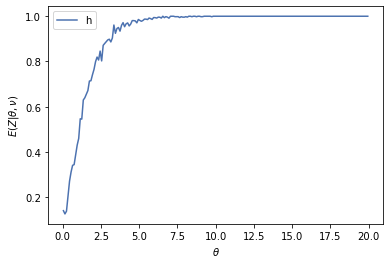

In [192]:
fig= plt.figure();ax=fig.add_subplot()

plot_one_hist(Bprime=100000, thetamin=0,thetamax=20, nu=3,N=1,M=1,MLE=True, nbins=200, ax=ax)

### Plot the histogrammed approximations for the MLE vs non-MLE cases for a single value of $\mathbf{\nu}$

In [234]:
def plot_data_one_nu(Bprime, thetamin, thetamax, nu, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(10, 6)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=2, 
                           ncols=3, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j].set_xlim(thetamin, thetamax-5)
        ax[j].set_ylim(0, 1)
        ax[j].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              nu, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        
        if func:
            p, _ = func(nu, N, M)
            ax[j].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        
        ax[j].grid(True, which="both", linestyle='-')
        ax[j].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j].text(10.1, 0.30, r'$\nu = %5.1f$' % nu, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j].legend(loc='upper right')
        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()


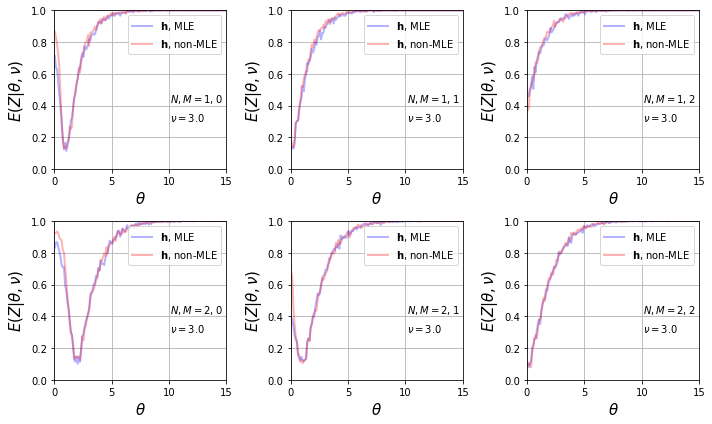

In [235]:
D = [ (N, M) for N in range(1,3) for M in range(3)]
plot_data_one_nu(Bprime=100000, thetamin=0, thetamax=20, nu=3, D=D, MLE=True)

### Plot the histogrammed approximations for the MLE vs non-MLE cases for multiple values of $\mathbf{\nu}$, indicating the dependence on the nuissance parameter

In [238]:
def plot_data(Bprime, thetamin, thetamax, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(15, 13)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=6, 
                           ncols=2, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    # ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        NU1=1
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU1, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 0].set_xlim(thetamin, thetamax-5)
        ax[j, 0].set_ylim(0, 1)
        ax[j, 0].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 0].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 0].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 0].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        ax[j, 0].grid(True, which="both", linestyle='-')
        ax[j, 0].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].text(10.1, 0.30, r'$\nu = %5.1f$' % NU1, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].legend(loc='upper right')
        ############define second nu value to see difference
        NU2=9
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU2, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 1].set_xlim(thetamin, thetamax-5)
        ax[j, 1].set_ylim(0, 1)
        ax[j, 1].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 1].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 1].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 1].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
         
        ax[j, 1].grid(True, which="both", linestyle='-')
        ax[j, 1].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].text(10.1, 0.30, r'$\nu = %5.1f$' % NU2, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].legend(loc='upper right')
        
        if func:
            p, _ = func(nu, N, M)
            ax[j, 0].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        

        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()

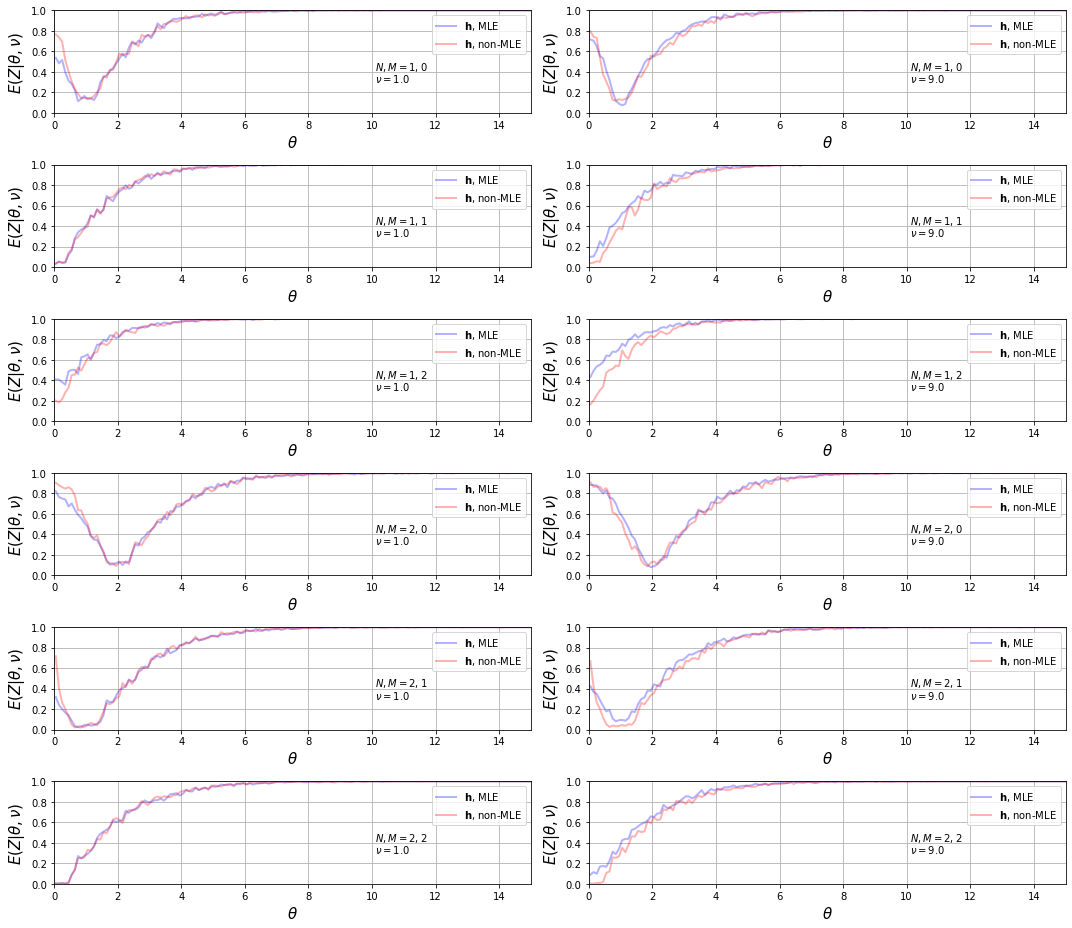

In [239]:
D = [ (N, M) for N in range(1,3) for M in range(3)]
plot_data(Bprime=100000, thetamin=0, thetamax=20, D=D, MLE=True)

### Define Model, which will approximate the expectation value above

In [240]:
class RegularizedRegressionModel(nn.Module):
    #inherit from the super class
    def __init__(self, nfeatures, ntargets, nlayers, hidden_size):
        super().__init__()
        layers = []
        for _ in range(nlayers):
            if len(layers) ==0:
                #inital layer has to have size of input features as its input layer
                #its output layer can have any size but it must match the size of the input layer of the next linear layer
                #here we choose its output layer as the hidden size (fully connected)
                layers.append(nn.Linear(nfeatures, hidden_size))
                #batch normalization
                layers.append(nn.BatchNorm1d(hidden_size))
                #ReLU activation 
                layers.append(nn.LeakyReLU())
            else:
                #if this is not the first layer (we dont have layers)
                layers.append(nn.Linear(hidden_size, hidden_size))
                layers.append(nn.BatchNorm1d(hidden_size))
                layers.append(nn.LeakyReLU())
                #output layer:
        layers.append(nn.Linear(hidden_size, ntargets)) 
        
        # ONLY IF ITS A CLASSIFICATION, ADD SIGMOID
        #layers.append(nn.Sigmoid())
            #we have defined sequential model using the layers in oulist 
        self.model = nn.Sequential(*layers)
            
    
    def forward(self, x):
        return self.model(x)

In [241]:
def average_quadratic_loss(f, t, x):
    # f and t must be of the same shape
    return  torch.mean((f - t)**2)

def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)




def validate(model, avloss, inputs, targets):
    # make sure we set evaluation mode so that any training specific
    # operations are disabled.
    model.eval() # evaluation mode
    
    with torch.no_grad(): # no need to compute gradients wrt. x and t
        x = torch.from_numpy(inputs).float()
        t = torch.from_numpy(targets).float()
        # remember to reshape!
        o = model(x).reshape(t.shape)
    return avloss(o, t, x)


def train(model, optimizer, avloss,
          batch_size, 
          n_iterations, traces, 
          step=10, window=10):
    
    # to keep track of average losses
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # n = len(valid_x)
    
    print('Iteration vs average loss')
    print("%10s\t%10s\t%10s" % \
          ('iteration', 'train-set', 'valid-set'))
    
    training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = get_data_sets(simulate_data=False, batchsize=batch_size)
    
    for ii in range(n_iterations):

        # set mode to training so that training specific 
        # operations such as dropout are enabled.
        model.train()
        
        # get a random sample (a batch) of data (as numpy arrays)
        batch_x, batch_t = next(training_set_features()), next(training_set_targets())
        

        with torch.no_grad(): # no need to compute gradients 
            # wrt. x and t
            x = torch.from_numpy(batch_x).float()
            t = torch.from_numpy(batch_t).float()      

        # compute the output of the model for the batch of data x
        # Note: outputs is 
        #   of shape (-1, 1), but the tensor targets, t, is
        #   of shape (-1,)
        # In order for the tensor operations with outputs and t
        # to work correctly, it is necessary that they have the
        # same shape. We can do this with the reshape method.
        outputs = model(x).reshape(t.shape)
   
        # compute a noisy approximation to the average loss
        empirical_risk = avloss(outputs, t, x)
        
        # use automatic differentiation to compute a 
        # noisy approximation of the local gradient
        optimizer.zero_grad()       # clear previous gradients
        empirical_risk.backward()   # compute gradients
        
        # finally, advance one step in the direction of steepest 
        # descent, using the noisy local gradient. 
        optimizer.step()            # move one step
        
        if ii % step == 0:
            batch_x_eval, batch_t_eval = next(evaluation_set_features()), next(evaluation_set_targets())
            
            acc_t = validate(model, avloss, batch_x, batch_t) 
            acc_v = validate(model, avloss, batch_x_eval, batch_t_eval)
            yy_t.append(acc_t)
            yy_v.append(acc_v)
            
            # compute running average for validation data
            len_yy_v = len(yy_v)
            if   len_yy_v < window:
                yy_v_avg.append( yy_v[-1] )
            elif len_yy_v == window:
                yy_v_avg.append( sum(yy_v) / window )
            else:
                acc_v_avg  = yy_v_avg[-1] * window
                acc_v_avg += yy_v[-1] - yy_v[-window-1]
                yy_v_avg.append(acc_v_avg / window)
                        
            if len(xx) < 1:
                xx.append(0)
                print("%10d\t%10.6f\t%10.6f" % \
                      (xx[-1], yy_t[-1], yy_v[-1]))
            else:
                xx.append(xx[-1] + step)
                    
                print("\r%10d\t%10.6f\t%10.6f\t%10.6f" % \
                          (xx[-1], yy_t[-1], yy_v[-1], yy_v_avg[-1]), 
                      end='')
            
    print()      
    return (xx, yy_t, yy_v, yy_v_avg)

def plot_average_loss(traces, ftsize=18,save_loss_plots=False):
    
    xx, yy_t, yy_v, yy_v_avg = traces
    
    # create an empty figure
    fig = plt.figure(figsize=(6, 4.5))
    fig.tight_layout()
    
    # add a subplot to it
    nrows, ncols, index = 1,1,1
    ax  = fig.add_subplot(nrows,ncols,index)

    ax.set_title("Average loss")
    
    ax.plot(xx, yy_t, 'b', lw=2, label='Training')
    ax.plot(xx, yy_v, 'r', lw=2, label='Validation')
    #ax.plot(xx, yy_v_avg, 'g', lw=2, label='Running average')

    ax.set_xlabel('Iterations', fontsize=ftsize)
    ax.set_ylabel('average loss', fontsize=ftsize)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid(True, which="both", linestyle='-')
    ax.legend(loc='upper right')
    if save_loss_plots:
        plt.savefig('images/loss_curves/IQN_'+N+T+'_Consecutive_2.png')
        print('\nloss curve saved in images/loss_curves/IQN_'+N+target+'_Consecutive.png')
    # if show_loss_plots:
    #     plt.show()

In [250]:
BATCHSIZE=100
training_set_features, training_set_targets, evaluation_set_features, evaluation_set_targets = \
get_data_sets(simulate_data=False, batchsize=BATCHSIZE)

sample_x=next(training_set_features())#this is just to get the dimenstions of one batch
sample_y=next(training_set_targets())
#(batchsize,5) for mass
print('sample x shape', sample_x.shape)
print('sample x shape', sample_y.shape)

n_features = sample_x.shape[1]
print('\n')
model =  RegularizedRegressionModel(nfeatures=sample_x.shape[1], 
                                    ntargets=1,
                                    nlayers=5, 
                                    hidden_size=5)
print(model)

sample x shape (100, 4)
sample x shape (100,)


RegularizedRegressionModel(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=5, bias=True)
    (1): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=5, out_features=5, bias=True)
    (4): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=5, out_features=5, bias=True)
    (7): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=5, out_features=5, bias=True)
    (10): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=5, out_features=5, bias=True)
    (13): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14

In [251]:
learning_rate = 1.e-3
optimizer     = torch.optim.Adam(model.parameters(), 
                                 lr=learning_rate) 
traces = ([], [], [], [])
traces_step = 100
n_iterations=20000

traces= train(model=model, optimizer=optimizer, avloss=average_quadratic_loss,
          batch_size=BATCHSIZE, 
          n_iterations=n_iterations, traces=traces, 
          step=traces_step, window=100)

Iteration vs average loss
 iteration	 train-set	 valid-set
         0	  0.696537	  0.740565
     19900	  0.090859	  0.083950	  0.104356


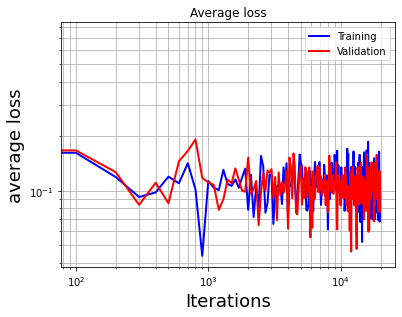

In [252]:
plot_average_loss(traces)

In [254]:
nbins=200
thetamin,thetamax=0,20
thetastep = (thetamax-thetamin) / nbins
bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
X     = (bb[1:] + bb[:-1])/2
X

array([ 0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,  0.85,
        0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,  1.65,  1.75,
        1.85,  1.95,  2.05,  2.15,  2.25,  2.35,  2.45,  2.55,  2.65,
        2.75,  2.85,  2.95,  3.05,  3.15,  3.25,  3.35,  3.45,  3.55,
        3.65,  3.75,  3.85,  3.95,  4.05,  4.15,  4.25,  4.35,  4.45,
        4.55,  4.65,  4.75,  4.85,  4.95,  5.05,  5.15,  5.25,  5.35,
        5.45,  5.55,  5.65,  5.75,  5.85,  5.95,  6.05,  6.15,  6.25,
        6.35,  6.45,  6.55,  6.65,  6.75,  6.85,  6.95,  7.05,  7.15,
        7.25,  7.35,  7.45,  7.55,  7.65,  7.75,  7.85,  7.95,  8.05,
        8.15,  8.25,  8.35,  8.45,  8.55,  8.65,  8.75,  8.85,  8.95,
        9.05,  9.15,  9.25,  9.35,  9.45,  9.55,  9.65,  9.75,  9.85,
        9.95, 10.05, 10.15, 10.25, 10.35, 10.45, 10.55, 10.65, 10.75,
       10.85, 10.95, 11.05, 11.15, 11.25, 11.35, 11.45, 11.55, 11.65,
       11.75, 11.85, 11.95, 12.05, 12.15, 12.25, 12.35, 12.45, 12.55,
       12.65, 12.75,

In [264]:
def make_eval_data(Bprime, thetamin, thetamax, nu, D, MLE, nbins):
    #if MLE true, load the model that was trained on MLE data and vice versa
    N, M = D
    # nbins=200
    # thetamin,thetamax=0,20
    thetastep = (thetamax-thetamin) / nbins
    bb    = np.arange(thetamin, thetamax+thetastep, thetastep)#this is just making a vector of thetas
    X     = (bb[1:] + bb[:-1])/2
    tensor = torch.Tensor([[x, nu, N, M] for x in X])
    return tensor

In [267]:
eval_data=make_eval_data(Bprime=100,thetamin=0,thetamax=20,nu=3, D=(0,1), MLE=True, nbins=300)
print(eval_data[:5])

tensor([[0.0333, 3.0000, 0.0000, 1.0000],
        [0.1000, 3.0000, 0.0000, 1.0000],
        [0.1667, 3.0000, 0.0000, 1.0000],
        [0.2333, 3.0000, 0.0000, 1.0000],
        [0.3000, 3.0000, 0.0000, 1.0000]])


In [268]:
eval_data.shape

torch.Size([300, 4])

In [56]:
data_2_param=pd.read_csv('data/TWO_PARAMETERS_TRAINING_DATA_1M.csv', nrows=10000, usecols=['theta','nu', 'N', 'M'])
data_2_param.head()

,theta,nu,N,M
0,19.597712,10.387874,5,6
1,13.316589,0.052172,1,6
2,9.565929,2.031794,3,6
3,19.145463,8.600285,9,3
4,7.994914,7.861142,8,2


In [ ]:
def usemodel(Bprime, thetamin, thetamax, D, MLE):
    nbins=200
    thetastep = (thetamax-thetamin) / nbins
    bb    = np.arange(xmin, xmax+xstep, xstep)#this is just making a vector of thetas
    X     = (bb[1:] + bb[:-1])/2
    X     = torch.Tensor([[x, nu, N, M] for x in X])
    
    model.eval()
    return model(X).detach().numpy(), bb

In [2]:
def plot_data(Bprime, thetamin, thetamax, D, MLE, 
              FONTSIZE=15,
              func=None,
              fgsize=(15, 13)):
    
    # make room for 6 sub-plots
    fig, ax = plt.subplots(nrows=6, 
                           ncols=2, 
                           figsize=fgsize)
    
    # padding
    plt.subplots_adjust(hspace=0.01)
    plt.subplots_adjust(wspace=0.20)
    
    # use flatten() to convert a numpy array of 
    # shape (nrows, ncols) to a 1-d array. 
    # ax = ax.flatten()
    
    for j, (N, M) in enumerate(D):
        NU1=1
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU1, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 0].set_xlim(thetamin, thetamax-5)
        ax[j, 0].set_ylim(0, 1)
        ax[j, 0].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 0].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 0].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 0].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
        ax[j, 0].grid(True, which="both", linestyle='-')
        ax[j, 0].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].text(10.1, 0.30, r'$\nu = %5.1f$' % NU1, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 0].legend(loc='upper right')
        ############define second nu value to see difference
        NU2=9
        y, bb = make_hist_data(Bprime,
                              thetamin, thetamax,
                               NU2, N, M,
                              nbins=200,
                              MLE=True)
    
        ax[j, 1].set_xlim(thetamin, thetamax-5)
        ax[j, 1].set_ylim(0, 1)
        ax[j, 1].set_xlabel(r'$\theta$', fontsize=FONTSIZE)
        ax[j, 1].set_ylabel(r'$E(Z|\theta, \nu)$', fontsize=FONTSIZE)
        
        x = (bb[1:]+bb[:-1])/2
        ax[j, 1].plot(x, y, 'b', lw=2, label='$\mathbf{h}$, MLE', alpha=0.3)
        #h is histogram approximation

        y_nonMLE, bb_nonMLE = make_hist_data(Bprime,
                              thetamin, thetamax,
                              NU1, N, M,
                              nbins=200,
                              MLE=False)
        
        
        x_nonMLE = (bb_nonMLE[1:]+bb_nonMLE[:-1])/2
        ax[j, 1].plot(x_nonMLE, y_nonMLE, 'r', lw=2, label='$\mathbf{h}$, non-MLE',alpha=0.3)
        
         
        ax[j, 1].grid(True, which="both", linestyle='-')
        ax[j, 1].text(10.1, 0.42, r'$N, M = %d, %d$' % (N, M), 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].text(10.1, 0.30, r'$\nu = %5.1f$' % NU2, 
                   # fontsize=FONTSIZE
                  ) 

        ax[j, 1].legend(loc='upper right')
        
        if func:
            p, _ = func(nu, N, M)
            ax[j, 0].plot(x, p, 'r', lw=2, label='f')
            #f is model approximation
        

        
    # hide unused sub-plots
    for k in range(j+1, len(ax)):
        ax[k].set_visible(False)
    
    plt.tight_layout()
    plt.show()

NameError: name 'XBINS' is not defined

Compare the histogrammed function $h(\theta, \nu, N, M)$ to the ML prediction functino $f(\theta, \nu, N, M)$ (which is trained to regress $Z$). 